# 使用SAM自动生成对象掩码

由于SAM可以有效地处理prompts，因此可以通过对图像上的大量prompts进行采样来生成整个图像的掩码。

类`SamAutomaticMaskGenerator` 用于实现这个功能. 它的工作原理是在图像上的网格中对单点输入的prompts进行采样，SAM可以从每个prompts中预测多个掩码。然后，对掩码进行质量过滤，并使用非极大值抑制进行去重复。这个类还支持额外的选项以进一步提高掩模的质量和数量，例如对图像的多个裁剪进行预测，或对掩模进行后处理以去除小的断开区域和孔洞。

## 加载一些库

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from dotenv import load_dotenv
import os

load_dotenv()

True

In [4]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## 示例图片

In [5]:
image = cv2.imread('./images/dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

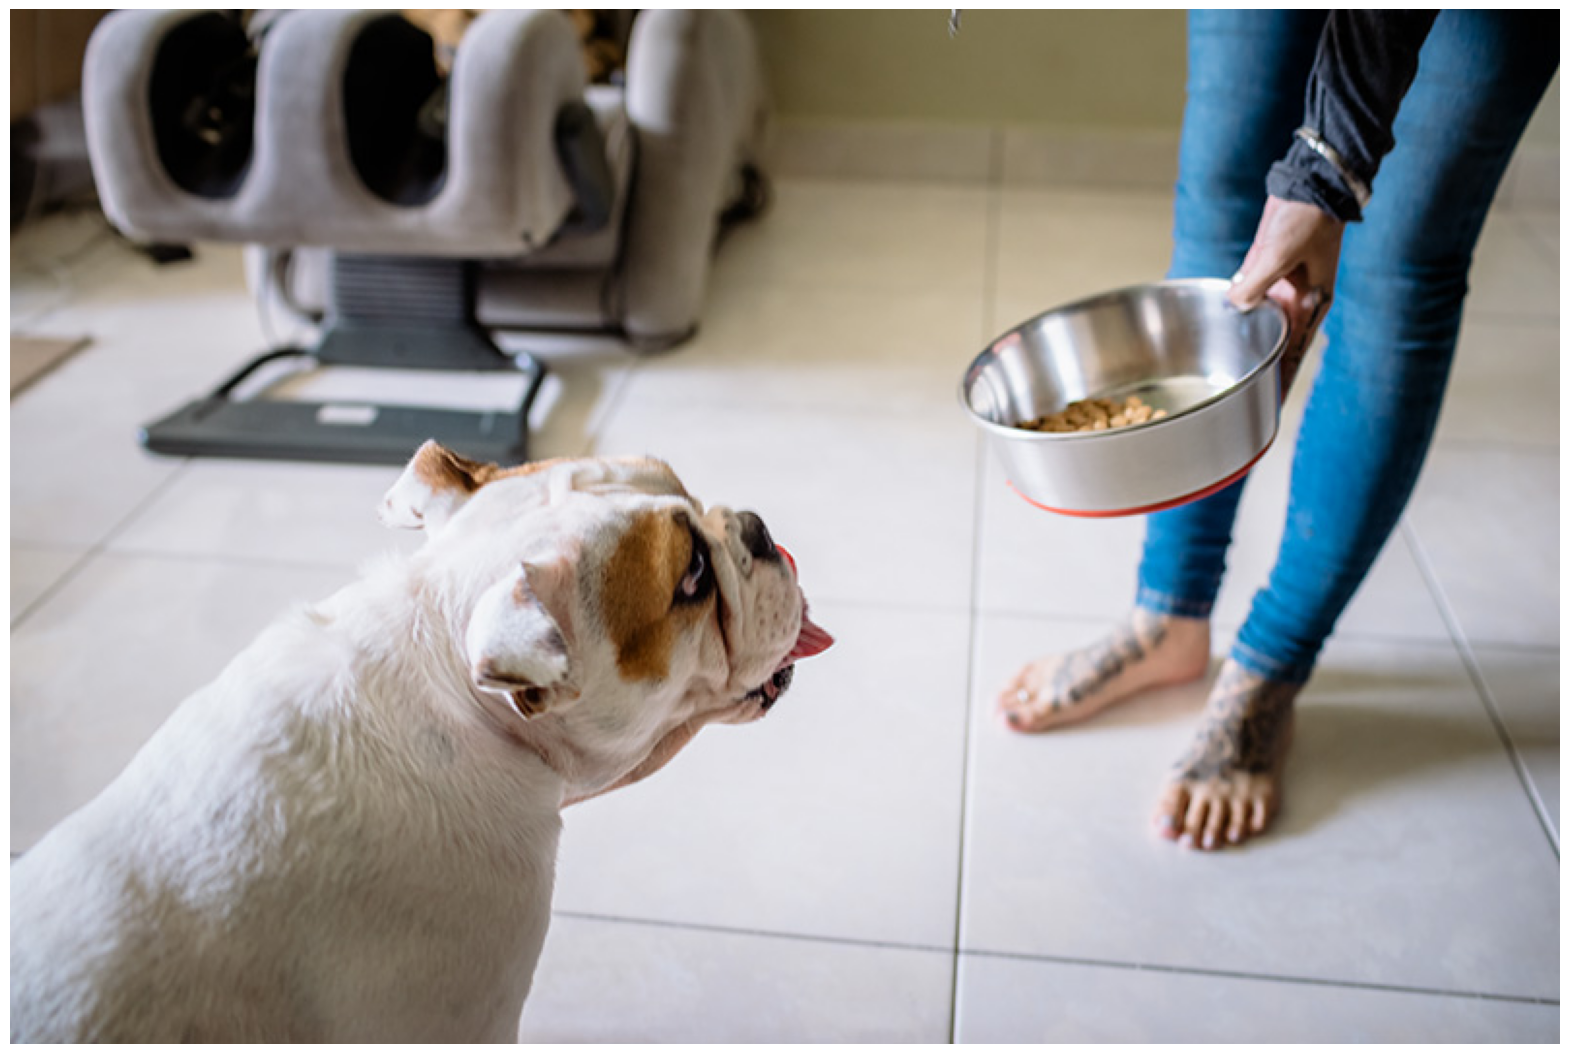

In [6]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## 自动生成mask

要实现mask的自动生成，需要向`SamAutomaticMaskGenerator`类提供SAM模型。

In [9]:
MODELS_FOLDER = os.getenv('MODEL_FOLDER_PATH')
model_folder_path= MODELS_FOLDER
OUR_UNET1_MODEL_File = os.path.join(model_folder_path+'sam_vit_h_4b8939.pth')
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = OUR_UNET1_MODEL_File
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

要生成mask，只需对图像运行`generate`方法即可。

In [10]:
masks = mask_generator.generate(image)

`generate`方法返回一个mask列表，其中每个mask是一个包含有关mask的各种数据的字典:
* `segmentation` : mask
* `area` : mask的面积（以像素为单位）
* `bbox` : XYWH格式的boundary box mask
* `predicted_iou` : 模型对mask质量的预测
* `point_coords` : 生成此mask的采样输入点
* `stability_score` : mask质量的另一个衡量标准
* `crop_box` : 用于以XYWH格式生成此mask的图像裁剪

In [11]:
print(len(masks))
print(masks[0].keys())

66
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


显示图像上的所有mask。

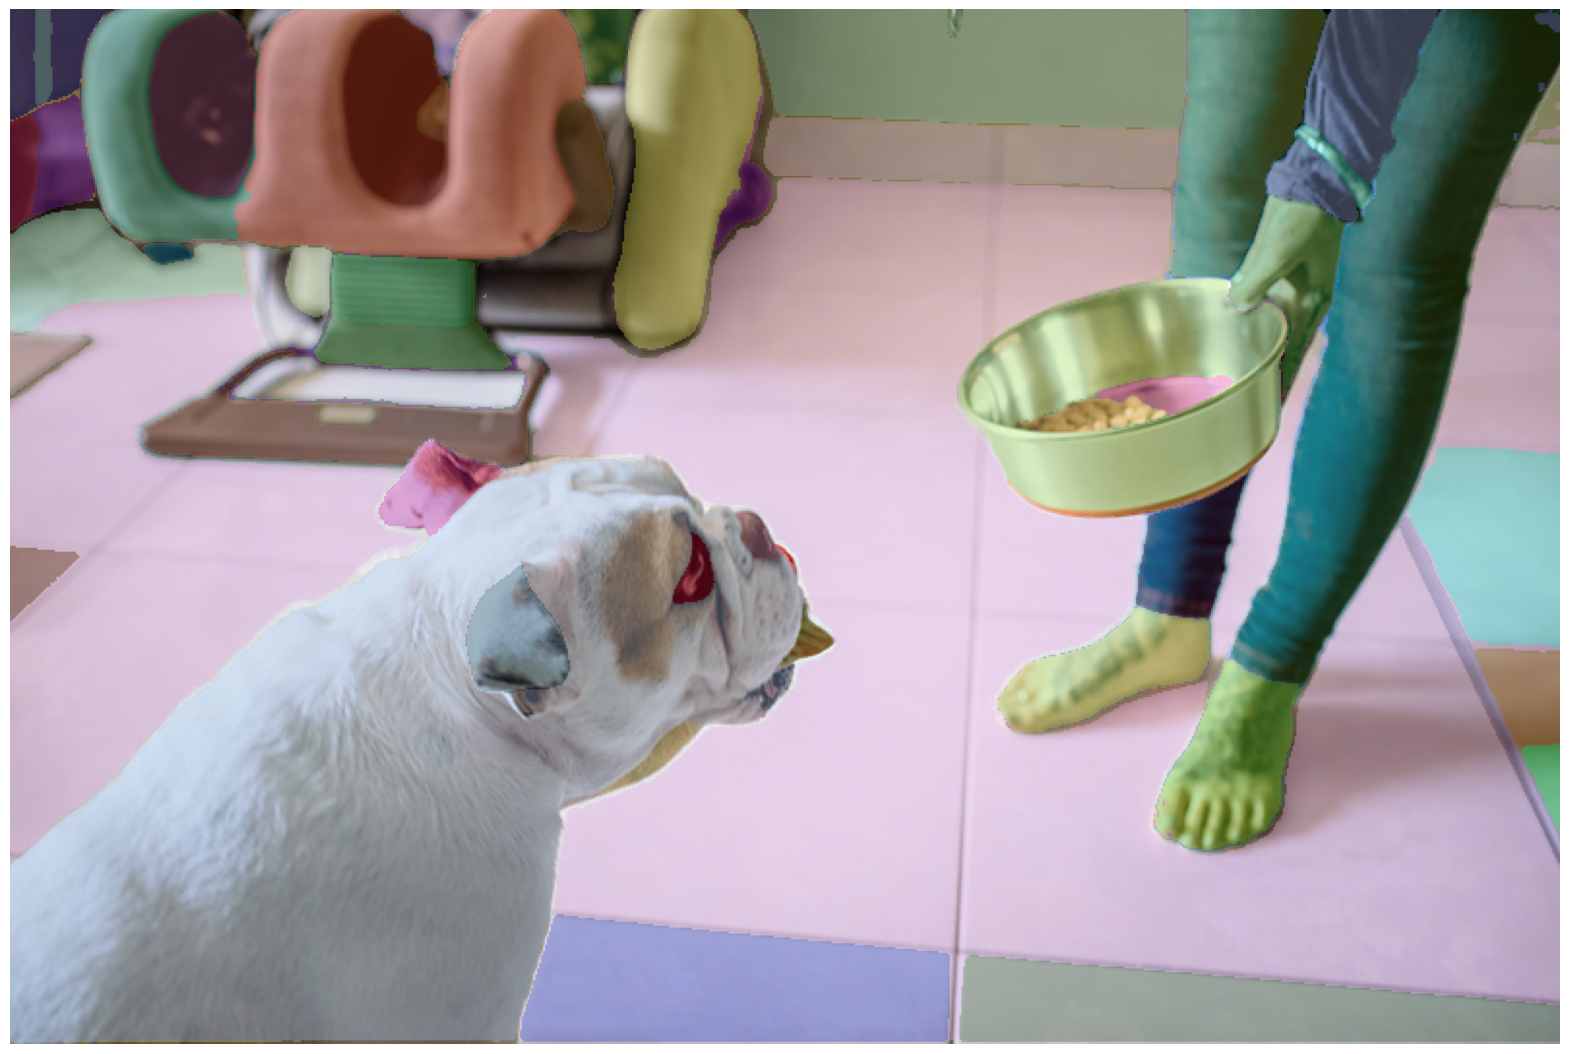

In [12]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## 自动掩码生成选项

在自动mask生成中有几个可调参数，用于控制采样点的密度以及去除低质量或重复掩模的阈值。此外，生成可以在图像的裁剪上自动运行，以提高模型处理小目标的性能，后处理可用于去除杂乱像素和孔洞。

In [13]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [14]:
masks2 = mask_generator_2.generate(image)

In [15]:
len(masks2)

90

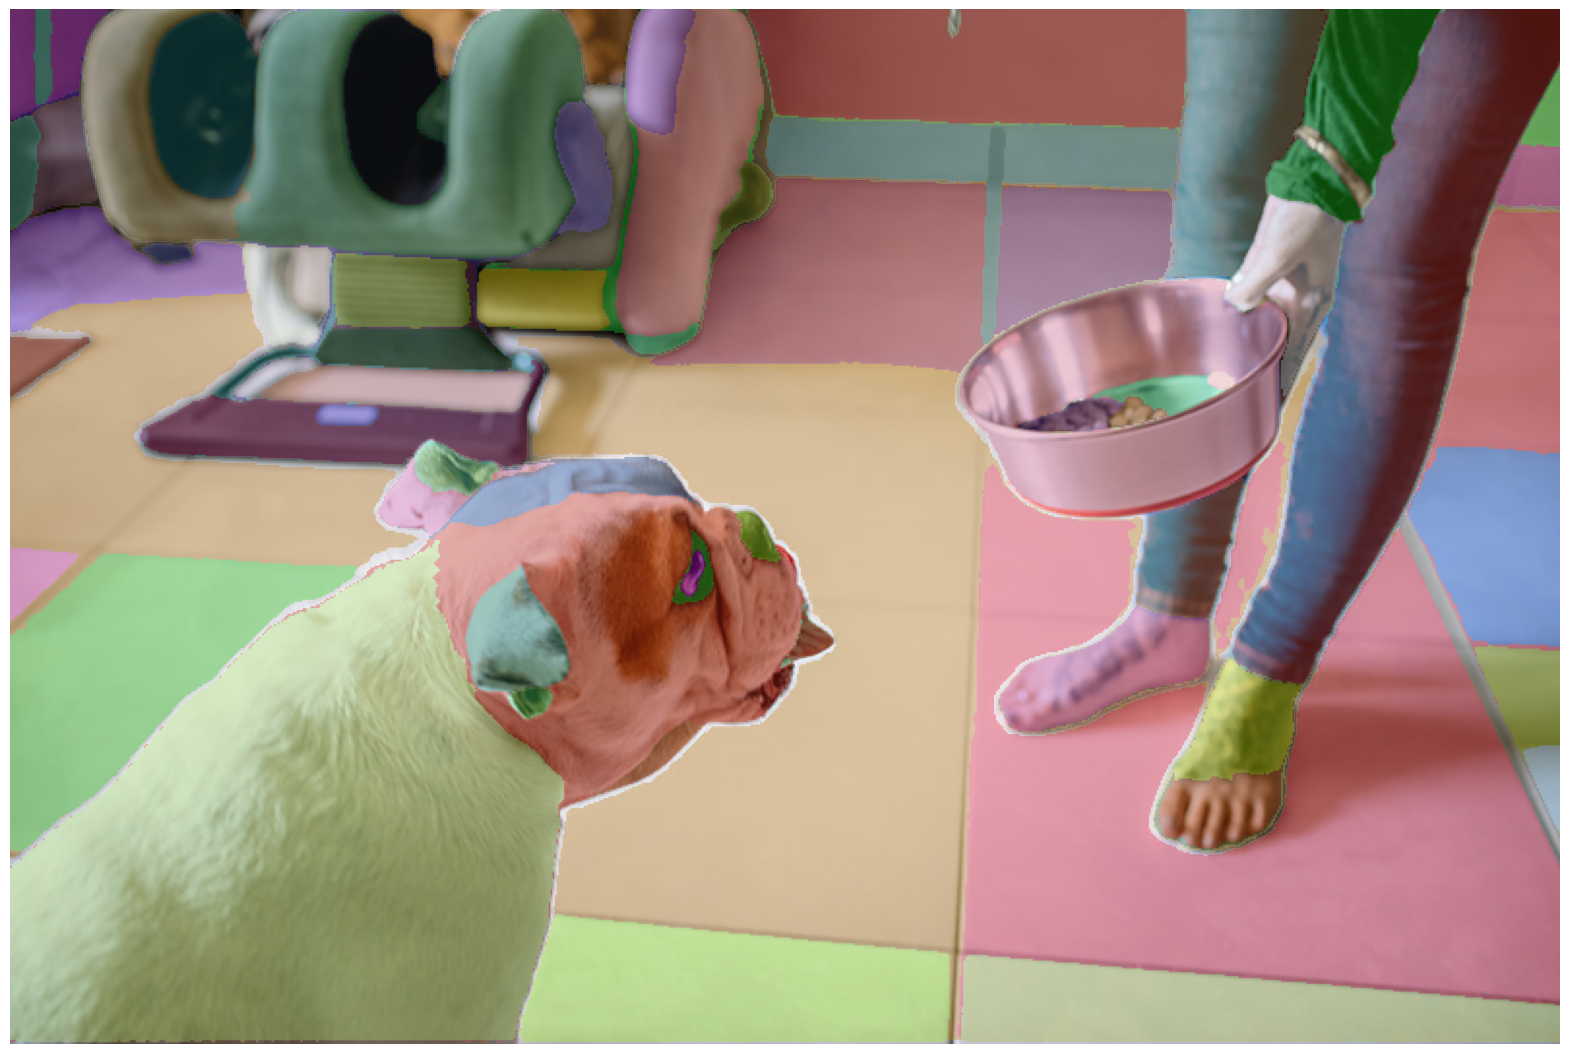

In [16]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 